In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path
import xhermes as xh

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/sdtool_load_test/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/transients"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))


from plotting_functions import *
from convergence_functions import * 

from hermes3.case_db import *
from hermes3.casedeck import*
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *
from hermes3.selectors import *
from hermes3.balance1d import *

# plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15



# plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 16})



%load_ext autoreload
%autoreload 2


# 2D

In [2]:
db = CaseDB(case_dir = '/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2025-01_STEP_1D-2D_comparison/Mike_2D_cases/m4ab-tune_albedo_new_branch', grid_dir='/users/jlb647/scratch/simulation_program/hermes-3_sim/sdtool_load_test/grids')

case = db.load_case_2D("m4ab-tune_albedo_new_branch", use_squash = True, verbose = True)

- Reading case m4ab-tune_albedo_new_branch
-----------------------
- Looking for squash file
- Squash file found. squash date 01/12/2025, 17:02:45, dmp file date 01/12/2025, 16:40:35

Unnormalising with xHermes


# 1D

In [3]:
fl_ex_1D = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2025-01_STEP_1D-2D_comparison/Include_flux_expansion/m4ab-tune_albedo_1D_sep_add_1_working_add_flux_expansion')

/mnt/scratch/users/jlb647/simulation_program/hermes-3_sim/analysis/hermes-3_venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [4]:
ds = fl_ex_1D.hermes.extract_1d_tokamak_geometry()

print(ds)

<xarray.Dataset>
Dimensions:                        (pos: 400, t: 2)
Coordinates:
    dx                             (pos) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    dy                             (pos) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    dz                             (pos) float64 dask.array<chunksize=(10,), meta=np.ndarray>
  * t                              (t) float64 0.007971 0.008023
    x                              int64 0
    y                              (pos) float64 0.05792 0.1736 ... 24.41 24.41
    z                              float64 3.142
  * pos                            (pos) float64 -0.1734 -0.05771 ... 24.18
Data variables: (12/89)
    Bxy                            (pos) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    Ed+_iz                         (t, pos) float64 dask.array<chunksize=(2, 10), meta=np.ndarray>
    Ed+_rec                        (t, pos) float64 dask.array<chunksize=(2, 10), meta=np.ndarray>
    Ed_

# 1D flux profile

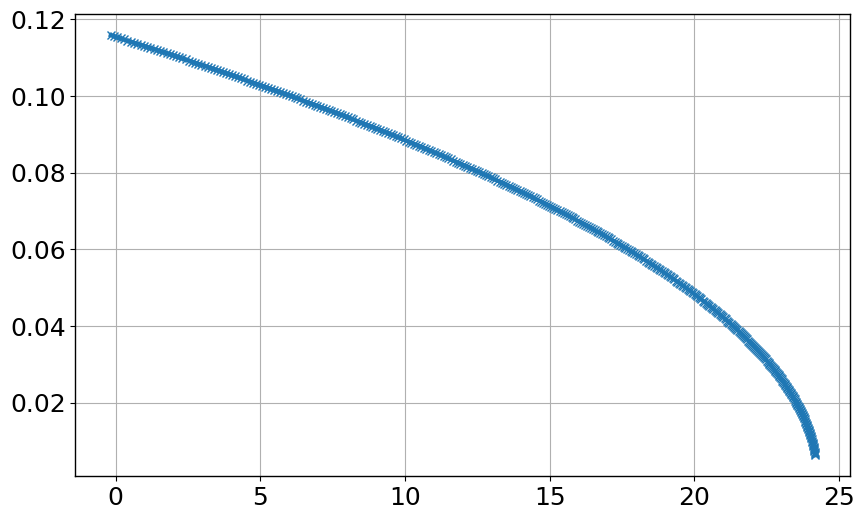

In [5]:

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
plt.plot(ds['pos'].values, ds['dy'].values, label = '1D', linewidth = linewidth, marker ='x')

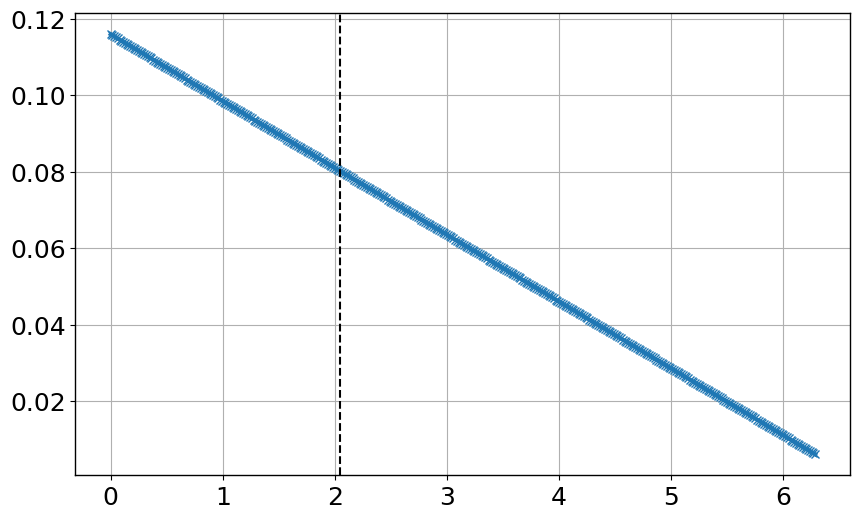

In [6]:
length = 24.41482754          # Length of the domain in meters
length_xpt = 12.781125972603952

pi = np.pi
ny = 400
dymin = 0.1

y = np.linspace(0, 2*pi, ny)

dy = (length / ny) * (1 + (1-dymin)*(1-y/pi))

# Calculate where the source ends in grid index (i.e. at the X-point)
source = length_xpt / length
y_xpt = pi * ( 2 - dymin - np.sqrt( (2-dymin)**2 - 4*(1-dymin)*source ) ) / (1 - dymin)



fig,ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(y, dy, label = '2D', linewidth = linewidth, marker = 'x')
ax.axvline(y_xpt, color = 'black', linestyle = '--', label = 'X-point')

## Dumb mode

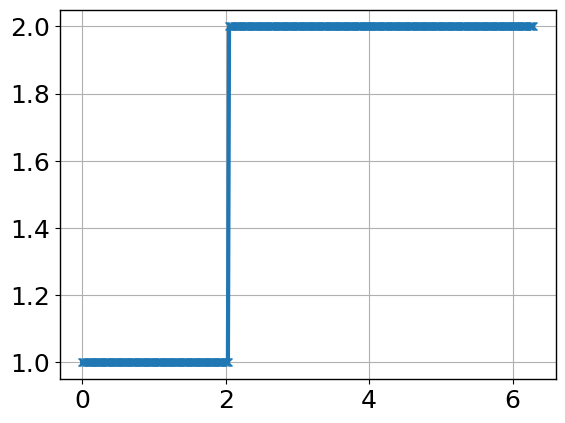

In [7]:
y = np.linspace(0, 2*pi, ny)

func = np.heaviside(y - y_xpt, 1)+1

plt.plot(y, func, label = '2D with flux expansion', linewidth = linewidth, marker = 'x')

# Linear

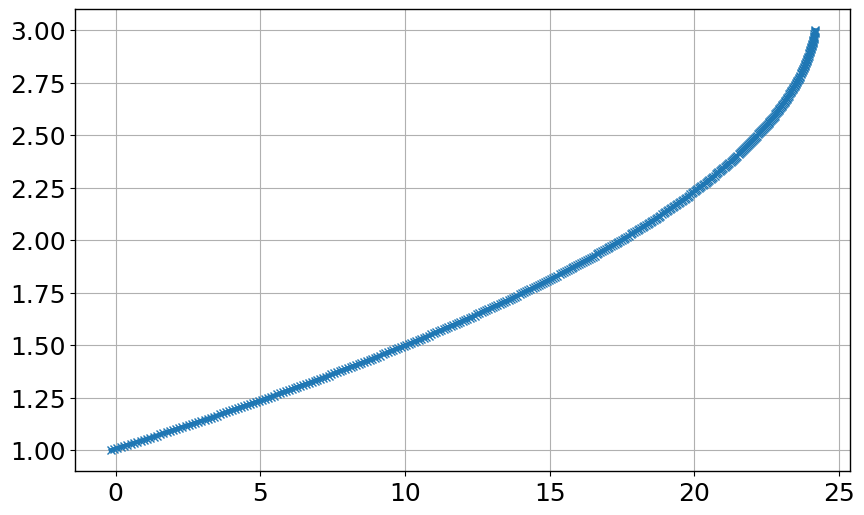

In [8]:
def f(y):
    return 1 + y / np.pi

fig,ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(ds['pos'], f(y), label = '1D', linewidth = linewidth, marker = 'x')



# 2D flux profile

In [9]:
params = ['R', 'Bxy', 'J']
profile = get_1d_poloidal_data(case.ds.isel(t=-1), params = params, region = ('outer_lower'), sepadd = 1)

f_expansion = 1/profile['Bxy']

x_sparce = profile['Spar']



# fig,ax = plt.subplots(1,1, figsize = (10,5))
# ax.plot(profile['Spar'], f_expansion, label = 'f_expansion', marker = 'o')

# print(x_sparce)

1 None


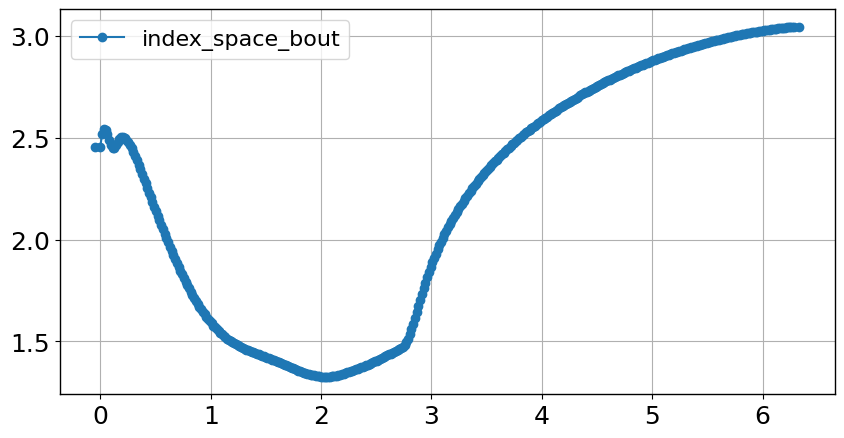

In [10]:
from scipy.interpolate import interp1d

x_old = profile['Spar'].values

# x_old = np.linspace(0, 2*pi, len(profile['Spar'].values))

# Mostly chatgpt
# x_rebase  = np.cumsum(dy)
# x_rebase = x_rebase - x_rebase[0]

# x_rebase = x_rebase[x_rebase < x_old[-1]]

x_rebase = ds['pos'].copy()

x_rebase = x_rebase.values

offset = 0.05

left = np.array([-offset])
right = np.array([x_rebase[-1]+offset])

x_rebase = np.concatenate((left, x_rebase, right))

interp_func = interp1d(x_old, f_expansion, kind = 'cubic', fill_value = 'extrapolate')

f_exp_rebase = interp_func(x_rebase)

f_exp_rebase[0] = f_exp_rebase[1]

f_exp_rebase[-1] = f_exp_rebase[-2]



dy_rebase = np.diff(x_rebase)



fig,ax = plt.subplots(1,1, figsize = (10,5))

# ax.plot(x_rebase, f_exp_rebase, label = '1/Bxy_rebase', marker = 'x')

# ax.plot(x_sparce, f_expansion, label = '1/Bxy', marker = 'o')


x_index_space = np.linspace(min(x_rebase), max(x_rebase), len(x_rebase))

x_index_space_bout = np.linspace(0, 2*np.pi, len(x_rebase)-2)

x_index_space_bout = np.concatenate((np.array([-offset]), x_index_space_bout, np.array([2*np.pi+offset])))




ax.plot(x_index_space_bout, f_exp_rebase, label = 'index_space_bout', marker = 'o')

# ax.plot(x_rebase, f_exp_rebase, label = '1/Bxy_rebase', marker = 'o')
# ax.plot(dy[:-1], dy_rebase, label = 'dy vs dy_rebase', marker = 'o')

ax.legend()

## Simplified grid

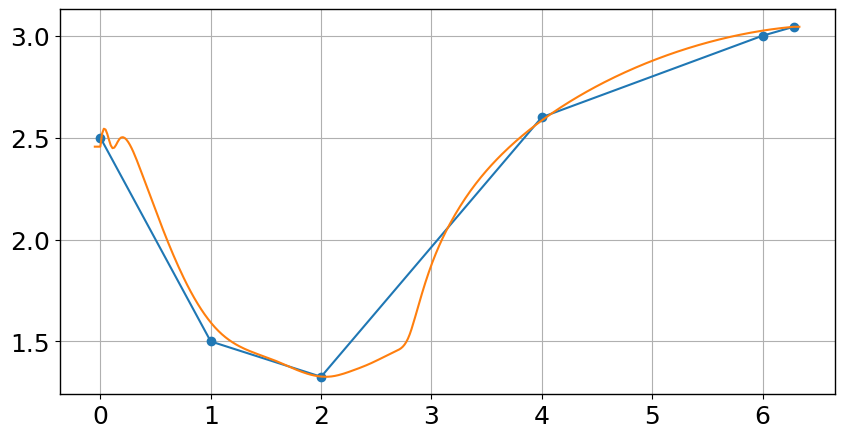

In [39]:
x_simp = np.array([0, 1,2,4, 6, 2*np.pi])
J_simp = np.array([2.5, 1.5, min(f_exp_rebase), 2.6, 3 , max(f_exp_rebase)])

fig,ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(x_simp, J_simp, label = 'J_simp', marker = 'o')
ax.plot(x_index_space_bout, f_exp_rebase, label = 'index_space_bout')

## Fitting procedure for 2D data

Fitted Polynomial Coefficients:
coef0= 2.439926
coef1= 2.269172
coef2= -12.745572
coef3= 20.741854
coef4= -17.747649
coef5= 8.985570
coef6= -2.806931
coef7= 0.545975
coef8= -0.064392
coef9= 0.004215
coef10= -0.000117


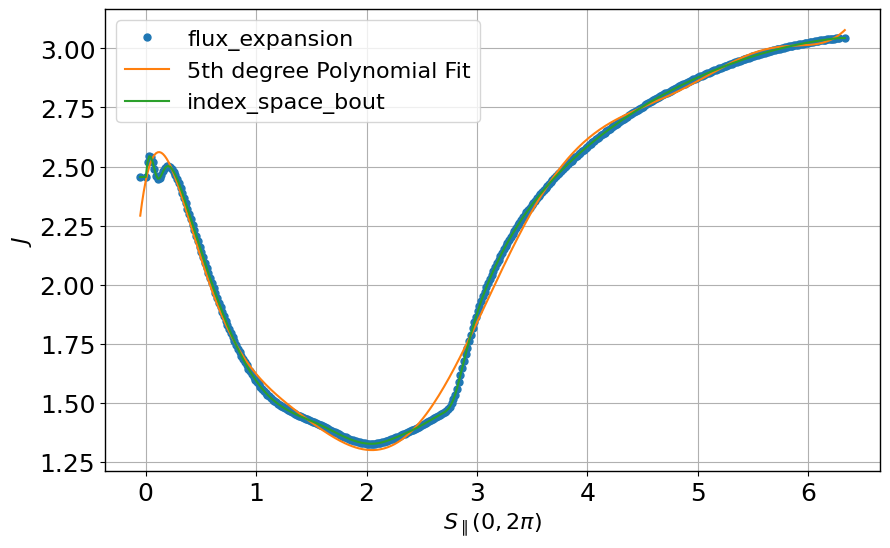

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these with your actual data


x_data = x_index_space_bout  # Add your x values here
y_data = f_exp_rebase

# Fit a 10th-degree polynomial
nth_poly = 5
coefficients = np.polyfit(x_data, y_data, 10)

# Generate the polynomial function
polynomial = np.poly1d(coefficients)

# Evaluate the polynomial for plotting
x_fit = np.linspace(min(x_data), max(x_data), 400)
y_fit = polynomial(x_fit)

# Print coefficients
print("Fitted Polynomial Coefficients:")
for i, coef in enumerate(coefficients[::-1]):
    print(f"coef{i}= {coef:.6f}")

# Plot the data and the fitted polynomial
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o', label="flux_expansion", markersize=5)
plt.plot(x_fit, y_fit, '-', label=f"{nth_poly}th degree Polynomial Fit")
plt.plot(x_index_space_bout, f_exp_rebase, label = 'index_space_bout')
plt.ylabel(r'$J$')
plt.xlabel(r"$S_{\parallel} (0 , 2\pi)$")
plt.legend()
plt.grid(True)
plt.show()


# Matt flux expansion

In [13]:
fe_matt = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2025-01_STEP_1D-2D_comparison/Include_flux_expansion/m4ab-tune_albedo_1D_sep_add_1_working_add_flux_expansion_matt')


/mnt/scratch/users/jlb647/simulation_program/hermes-3_sim/analysis/hermes-3_venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [64]:
fe_me = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2025-01_STEP_1D-2D_comparison/Include_flux_expansion/flux_exp_test')

/mnt/scratch/users/jlb647/simulation_program/hermes-3_sim/analysis/hermes-3_venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


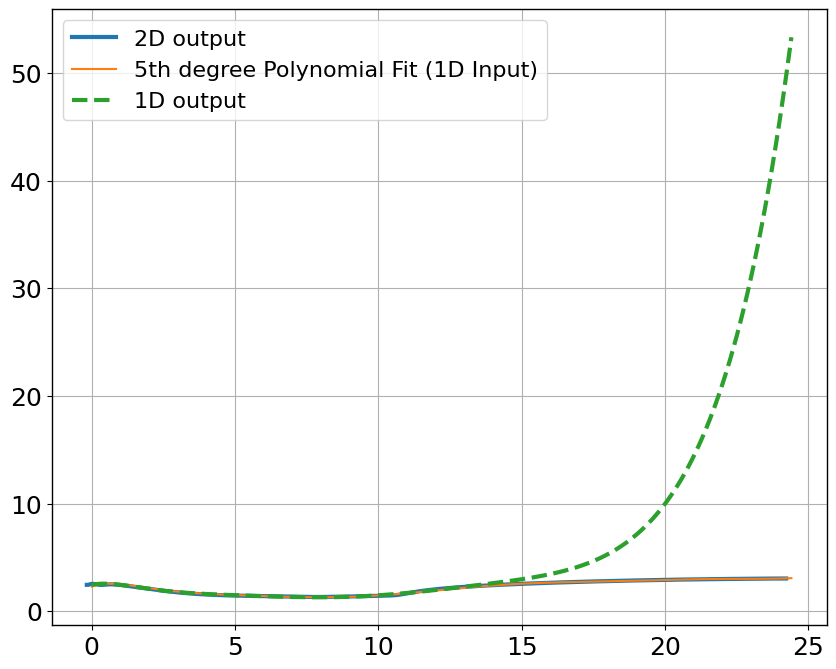

In [65]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))

y_lin = np.linspace(0, np.max(fe_matt['y'].values), len(fe_matt['y'].values))

# plt.plot(y_lin, fe_matt['J'][0], label = 'matt', linewidth = linewidth, marker = 'o')
ax.plot(x_index_space, f_exp_rebase, label = '2D output', linewidth = linewidth)
ax.plot(y_lin, y_fit, label=f"{nth_poly}th degree Polynomial Fit (1D Input)")
ax.plot(y_lin, fe_me['J'][0], label = '1D output', linewidth = linewidth, linestyle = '--')
ax.plot()
ax.legend()